<a href="https://colab.research.google.com/github/Dulyaaa/Deep_-Learning/blob/main/GNN/GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --verbose --no-cache-dir torch-scatter
!pip install --verbose --no-cache-dir torch-sparse
!pip install --verbose --no-cache-dir torch-cluster
!pip install torch-geometric
!pip install tensorboardX
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

Using pip 24.1.2 from /usr/local/lib/python3.12/dist-packages/pip (python 3.12)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 37.2 MB/s eta 0:00:00
  Running command python setup.py egg_info
  running egg_info
  creating /tmp/pip-pip-egg-info-s1f6u4xt/torch_scatter.egg-info
  writing /tmp/pip-pip-egg-info-s1f6u4xt/torch_scatter.egg-info/PKG-INFO
  writing dependency_links to /tmp/pip-pip-egg-info-s1f6u4xt/torch_scatter.egg-info/dependency_links.txt
  writing requirements to /tmp/pip-pip-egg-info-s1f6u4xt/torch_scatter.egg-info/requires.txt
  writing top-level names to /tmp/pip-pip-egg-info-s1f6u4xt/torch_scatter.egg-info/top_level.txt
  writing manifest file '/tmp/pip-pip-egg-info-s1f6u4xt/torch_scatter.egg-info/SOURCES.txt'
  reading manifest file '/tmp/pip-pip-egg-info-s1f6u4xt/torch_scatter.egg-info/SOURCES.txt'
  reading manifest template 'MANIFEST.in'
  adding license file 'LICENSE'
  writing manifest file '/tmp/pip-pip-egg-info-s1f6u4xt/torch_scatter.egg-info/SOURCES

In [2]:
!pip install --verbose --no-cache-dir torch-scatter
!pip install --verbose --no-cache-dir torch-sparse
!pip install --verbose --no-cache-dir torch-cluster
!pip install torch-geometric
!pip install tensorboardX

Using pip 24.1.2 from /usr/local/lib/python3.12/dist-packages/pip (python 3.12)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 16.2 MB/s eta 0:00:00
  Running command python setup.py egg_info
  running egg_info
  creating /tmp/pip-pip-egg-info-dnkwo35f/torch_scatter.egg-info
  writing /tmp/pip-pip-egg-info-dnkwo35f/torch_scatter.egg-info/PKG-INFO
  writing dependency_links to /tmp/pip-pip-egg-info-dnkwo35f/torch_scatter.egg-info/dependency_links.txt
  writing requirements to /tmp/pip-pip-egg-info-dnkwo35f/torch_scatter.egg-info/requires.txt
  writing top-level names to /tmp/pip-pip-egg-info-dnkwo35f/torch_scatter.egg-info/top_level.txt
  writing manifest file '/tmp/pip-pip-egg-info-dnkwo35f/torch_scatter.egg-info/SOURCES.txt'
  reading manifest file '/tmp/pip-pip-egg-info-dnkwo35f/torch_scatter.egg-info/SOURCES.txt'
  reading manifest template 'MANIFEST.in'
  adding license file 'LICENSE'
  writing manifest file '/tmp/pip-pip-egg-info-dnkwo35f/torch_scatter.egg-info/SOURCES

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import sklearn.metrics as metrics

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

import networkx as nx
import numpy as np
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.transforms as T

from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [4]:
BATCH_SIZE = 32

# transformations
transform = transforms.Compose([transforms.ToTensor()])

# download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

# download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

100%|██████████| 9.91M/9.91M [00:00<00:00, 14.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 369kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.22MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.1MB/s]


In [5]:
class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, task='node'):
        super(GNNStack, self).__init__()
        self.task = task
        self.convs = nn.ModuleList()
        self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        self.lns = nn.ModuleList()
        self.lns.append(nn.LayerNorm(hidden_dim))
        self.lns.append(nn.LayerNorm(hidden_dim))
        for l in range(2):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.25),
            nn.Linear(hidden_dim, output_dim))
        if not (self.task == 'node' or self.task == 'graph'):
            raise RuntimeError('Unknown task.')

        self.dropout = 0.25
        self.num_layers = 3

    def build_conv_model(self, input_dim, hidden_dim):
        # refer to pytorch geometric nn module for different implementation of GNNs.
        if self.task == 'node':
            return pyg_nn.GCNConv(input_dim, hidden_dim)
        else:
            return pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                  nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if data.num_node_features == 0:
          x = torch.ones(data.num_nodes, 1)

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if not i == self.num_layers - 1:
                x = self.lns[i](x)

        if self.task == 'graph':
            x = pyg_nn.global_mean_pool(x, batch)

        x = self.post_mp(x)

        return emb, F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [6]:
def train(dataset, task, writer):
    if task == 'graph':
        data_size = len(dataset)
        loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=64, shuffle=True)
        test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=64, shuffle=True)
    else:
        test_loader = loader = DataLoader(dataset, batch_size=64, shuffle=True)

    # build model
    model = GNNStack(max(dataset.num_node_features, 1), 32, dataset.num_classes, task=task)
    opt = optim.Adam(model.parameters(), lr=0.01)

    # train
    for epoch in range(200):
        total_loss = 0
        model.train()
        for batch in loader:
            #print(batch.train_mask, '----')
            opt.zero_grad()
            embedding, pred = model(batch)
            label = batch.y
            if task == 'node':
                pred = pred[batch.train_mask]
                label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        writer.add_scalar("loss", total_loss, epoch)

        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            print("Epoch {}. Loss: {:.4f}. Test accuracy: {:.4f}".format(
                epoch, total_loss, test_acc))
            writer.add_scalar("test accuracy", test_acc, epoch)

    return model

In [7]:
def test(loader, model, is_validation=False):
    model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad():
            emb, pred = model(data)
            pred = pred.argmax(dim=1)
            label = data.y

        if model.task == 'node':
            mask = data.val_mask if is_validation else data.test_mask
            # node classification: only evaluate on nodes in test set
            pred = pred[mask]
            label = data.y[mask]

        correct += pred.eq(label).sum().item()

    if model.task == 'graph':
        total = len(loader.dataset)
    else:
        total = 0
        for data in loader.dataset:
            total += torch.sum(data.test_mask).item()
    return correct / total

In [8]:
get_ipython().system_raw(
'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
.format("./log")
)
get_ipython().system_raw('./ngrok http 6006 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c \
"import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.12/json/__init__.py", line 293, in load
    return loads(fp.read(),
           ^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/json/__init__.py", line 346, in loads
    return _default_decoder.decode(s)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/json/decoder.py", line 338, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/json/decoder.py", line 356, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


In [11]:
writer = SummaryWriter('./log/' + datetime.now().strftime('%Y%m%d-%H%M%S'))
dataset = Planetoid(root='/tmp/Cora', name='Cora')
task = 'node'
model = train(dataset, task, writer)

Processing...
Done!
/tmp/ipython-input-1552561886.py:7: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  test_loader = loader = DataLoader(dataset, batch_size=64, shuffle=True)


Epoch 0. Loss: 1.9647. Test accuracy: 0.2550
Epoch 10. Loss: 0.2872. Test accuracy: 0.7710
Epoch 20. Loss: 0.1005. Test accuracy: 0.7500
Epoch 30. Loss: 0.0303. Test accuracy: 0.7450
Epoch 40. Loss: 0.0382. Test accuracy: 0.7420
Epoch 50. Loss: 0.0184. Test accuracy: 0.7500
Epoch 60. Loss: 0.0543. Test accuracy: 0.7500
Epoch 70. Loss: 0.0073. Test accuracy: 0.7310
Epoch 80. Loss: 0.0007. Test accuracy: 0.7390
Epoch 90. Loss: 0.0464. Test accuracy: 0.7340
Epoch 100. Loss: 0.0023. Test accuracy: 0.7270
Epoch 110. Loss: 0.0013. Test accuracy: 0.7310
Epoch 120. Loss: 0.0023. Test accuracy: 0.7400
Epoch 130. Loss: 0.0005. Test accuracy: 0.7410
Epoch 140. Loss: 0.0003. Test accuracy: 0.7370
Epoch 150. Loss: 0.0207. Test accuracy: 0.7590
Epoch 160. Loss: 0.0030. Test accuracy: 0.7360
Epoch 170. Loss: 0.0071. Test accuracy: 0.7370
Epoch 180. Loss: 0.0191. Test accuracy: 0.7450
Epoch 190. Loss: 0.0010. Test accuracy: 0.7520


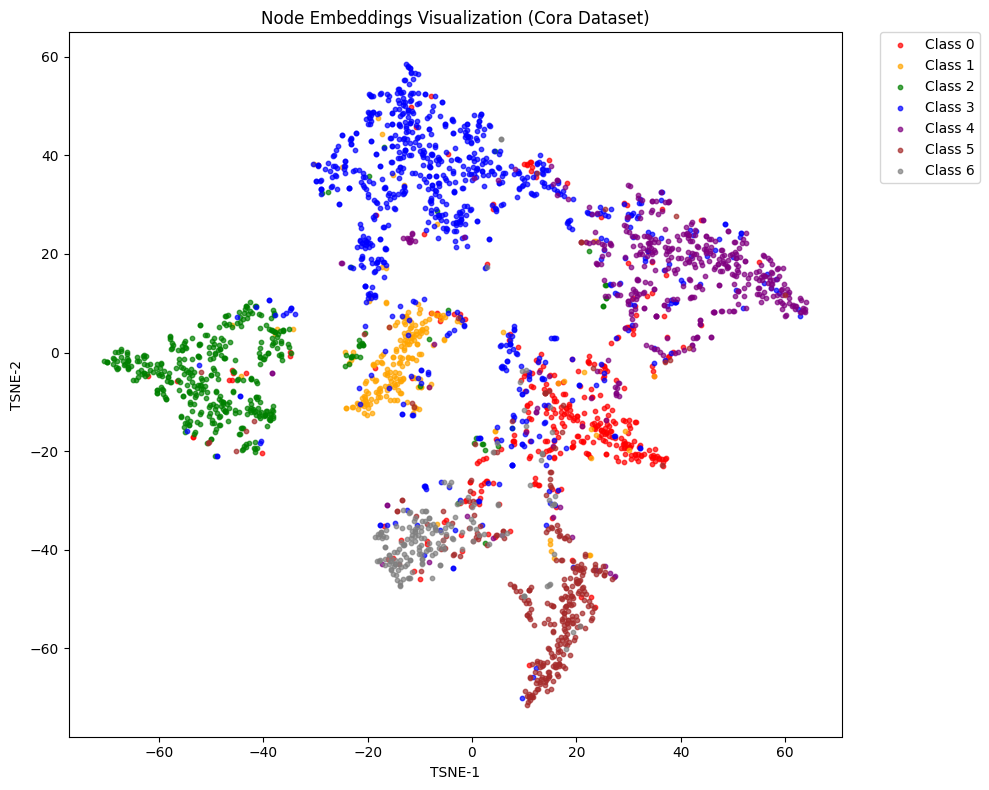

In [13]:
color_list = ["red", "orange", "green", "blue", "purple", "brown", "gray"] # Ensure enough colors for Cora (7 classes)

# Access the single graph data object from the Planetoid dataset
data = dataset[0]

# Generate embeddings from the trained model
# Ensure data is on the same device as the model if model is on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
model.to(device)

model.eval() # Set model to evaluation mode
with torch.no_grad():
    emb, pred = model(data)

# Extract embeddings and labels
embs = emb.detach().cpu().numpy()
labels = data.y.cpu().numpy()

# Apply t-SNE for dimensionality reduction
tsne_results = TSNE(n_components=2, random_state=42).fit_transform(embs)
xs, ys = tsne_results[:, 0], tsne_results[:, 1]

plt.figure(figsize=(10, 8))
# Create a scatter plot, coloring points by their original labels
for i, color in enumerate(color_list[:dataset.num_classes]): # Iterate through classes and their colors
    # Select embeddings and t-SNE coordinates for the current class
    class_mask = (labels == i)
    plt.scatter(xs[class_mask], ys[class_mask], color=color, label=f'Class {i}', s=10, alpha=0.7)

plt.title('Node Embeddings Visualization (Cora Dataset)')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.) # Place legend outside
plt.tight_layout() # Adjust layout to prevent labels from being cut off
plt.show()